There are over 200,000 pokemon images, I would not want to webscrape as it could results in DoS attack on their site and i could get banned.
There is a unique naming system with their sprites. I can use the unique fusiondex entries to determine the fusion and ultimately the type

# get name and type data

In [1]:
types = set()

with open('types.txt', 'r') as file:
    for line in file:
        types.add(line.strip().lower())

In [2]:
"""
Pokemon: 1
Bulbasaur
grasspoison
417/470
 
(88%)
444/470
"""

pokedex = {}

count = 1
with open('raw_dex_entries.txt', 'r') as file:
    data = file.read().split("\n")
    i = 0
    while i < len(data):
        line = data[i]
        if line not in [" ", "", "\n"]:
            tmp = line.split()
            if tmp[0] == "Pokemon:":
                dex_entry = {}
                i += 1
                dex_entry["name"] = data[i]
                i += 1
                if data[i] in types: # get type data
                    dex_entry["type"] = [data[i]]
                else:
                    j = 0
                    while j < len(data[i]): # get multitype
                        if data[i][:j] in types:
                            break
                        j += 1
                    dex_entry["type"] = [data[i][:j], data[i][j:]]
                pokedex[tmp[1]] = dex_entry      
        i += 1

In [3]:
pokedex["47"] # from [1-470]

{'name': 'Parasect', 'type': ['bug', 'grass']}

In [4]:
import os
import re

directory_path = '/blue/rcstudents/smaley/pokegan/customsprites/blk_bg/input'
# only up to number 470 in this directory

all_pokemon = {}
count = 0

for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    if os.path.isfile(file_path):
        count += 1
        pokemon = {}
        
        file_name = os.path.basename(file_path).split(".")
        body, head = file_name[0], file_name[1]
        
        poke_id = ""
        if head != "png": # if a fusion
            poke_id = body + "." + head
            pokemon["body"] = re.sub(r'[a-zA-Z]', '', body)
            pokemon["head"] = re.sub(r'[a-zA-Z]', '', head)
        else:
            poke_id = body
            pokemon["body"] = body
            pokemon["head"] = None
        all_pokemon[poke_id] = pokemon

In [5]:
count

116643

In [6]:
# tag all_pokemon with actual type

In [7]:
all_pokemon_to_type = {}

for pokedex_id in all_pokemon:
    body = all_pokemon[pokedex_id]["body"]
    head = all_pokemon[pokedex_id]["head"]
    
    entry = {}
    name = pokedex[body]["name"]
    
    body_type = pokedex[body]["type"][0]
    head_type = None
    
    entry["type"] = [body_type]
    if head:
        name += "/" + pokedex[head]["name"]
        head_types = pokedex[head]["type"]
        if len(head_types) > 1 and head_types[1] not in entry["type"]:
            entry["type"].append(head_types[1])
        elif head_types[0] not in entry["type"]:
            entry["type"].append(head_types[0])
    
    entry["name"] = name
    entry["body"] = body
    entry["head"] = head
    all_pokemon_to_type[pokedex_id] = entry

In [8]:
import csv

with open("all_pokemon_to_type.csv", mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Key', 'Type', 'Name', 'Body', 'Head'])
    for key, value in all_pokemon_to_type.items():
        writer.writerow([key, ', '.join(value['type']), value['name'], value['body'], value['head']])

# get dataset metrics

In [9]:
type_count = {}

for pokedex_id in all_pokemon_to_type:
    for poke_type in all_pokemon_to_type[pokedex_id]["type"]:
        if poke_type in type_count:
            type_count[poke_type] += 1
        else:
            type_count[poke_type] = 1

In [10]:
type_count

{'poison': 13883,
 'ground': 14034,
 'dark': 8369,
 'ice': 5197,
 'grass': 14706,
 'psychic': 16481,
 'fairy': 10039,
 'water': 22315,
 'normal': 24675,
 'electric': 11921,
 'flying': 12897,
 'dragon': 9447,
 'ghost': 13543,
 'steel': 9591,
 'fighting': 7631,
 'rock': 9132,
 'bug': 10252,
 'fire': 13140}

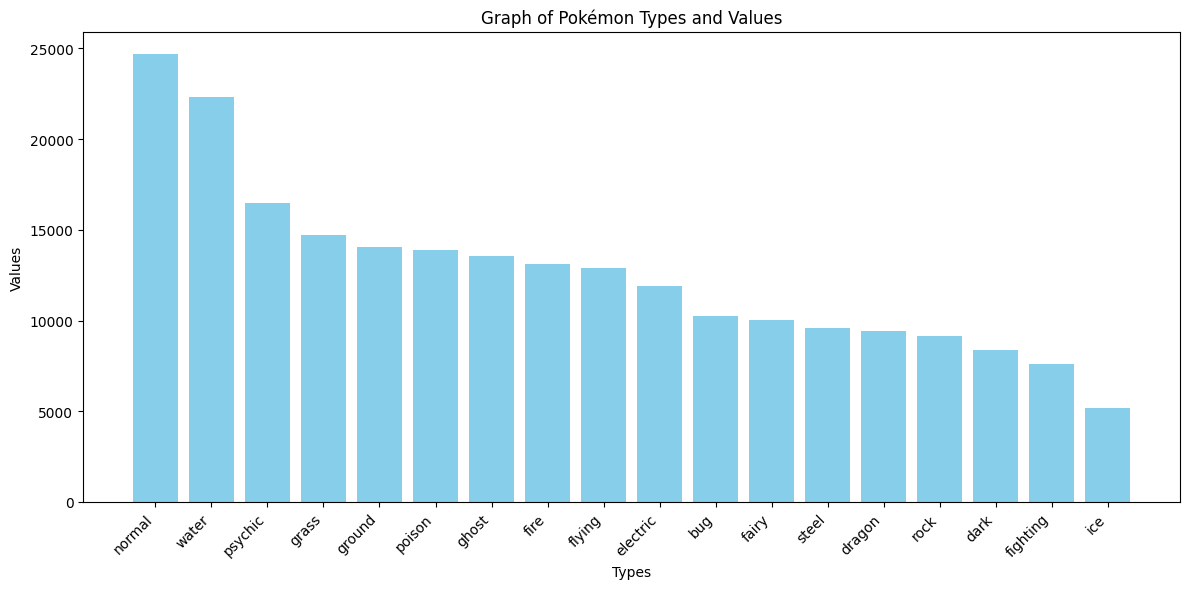

In [11]:
import matplotlib.pyplot as plt

sorted_data = dict(sorted(type_count.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(12, 6))
plt.bar(sorted_data.keys(), sorted_data.values(), color='skyblue')

plt.xlabel('Types')
plt.ylabel('Values')
plt.title('Graph of Pokémon Types and Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# split train, test, val

In [12]:
import pandas as pd

df = pd.read_csv('all_pokemon_to_type.csv')
df.drop('Body', axis=1, inplace=True)
df.drop('Head', axis=1, inplace=True)

In [13]:
types = []
with open('types.txt', 'r') as file:
    for line in file:
        types.append(line.strip().lower())
for col in types:
    df[col] = 0

In [14]:
for idx, row in df.iterrows():
    types = row['Type'].split(', ')
    for type_ in types:
        if type_ in df.columns:
            df.at[idx, type_] = 1

In [15]:
train_df = df.sample(frac=0.7)
test_df = df.loc[~df.index.isin(train_df.index)]

In [16]:
train_df.to_csv('train.csv', index=False)

In [17]:
test_df.to_csv('test.csv', index=False)

In [18]:
common_keys = set(train_df['Key']).intersection(set(test_df['Key']))

In [19]:
common_keys # no common keys

set()